<a href="https://colab.research.google.com/github/Pedro-Ortega-G/P_ESTOCASTICOS/blob/main/parimpar_mlp_concatena_p_ok_080325.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este cuaderno carga desde el ambiente de Colab una base de datos (energy_dataseet.csv) de generación de energia eléctrica de diferentes tipos; de entre los tipos de generación disponibles en la bases de datos se selecciona "generation_biomass" como serie de tiempo a procesar; se le aplica un preprocesamiento rellenando los valores faltantes (interpolación lineal); se divide la serie en dos sub-series (muestras pares e impares); se entrena un mlp (MinMaxScaler, 3 capas densas de 64, 32 y 1 neuronas con activación relu, 50 épocas, lotes de 32  muestras) para cada sub-serie (80% de datos para entrenamiento y 20% para validación); luego se concantenan y se comparan con la señal original y se genera una visualización adicional de las últimas 200 muestras.

<ipython-input-1-69f9fd907d1f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")
<ipython-input-1-69f9fd907d1f>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grupo_pares["generation biomass"] = scaler_pares.fit_transform(grupo_pares[["generation biomass"]])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. Whe

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


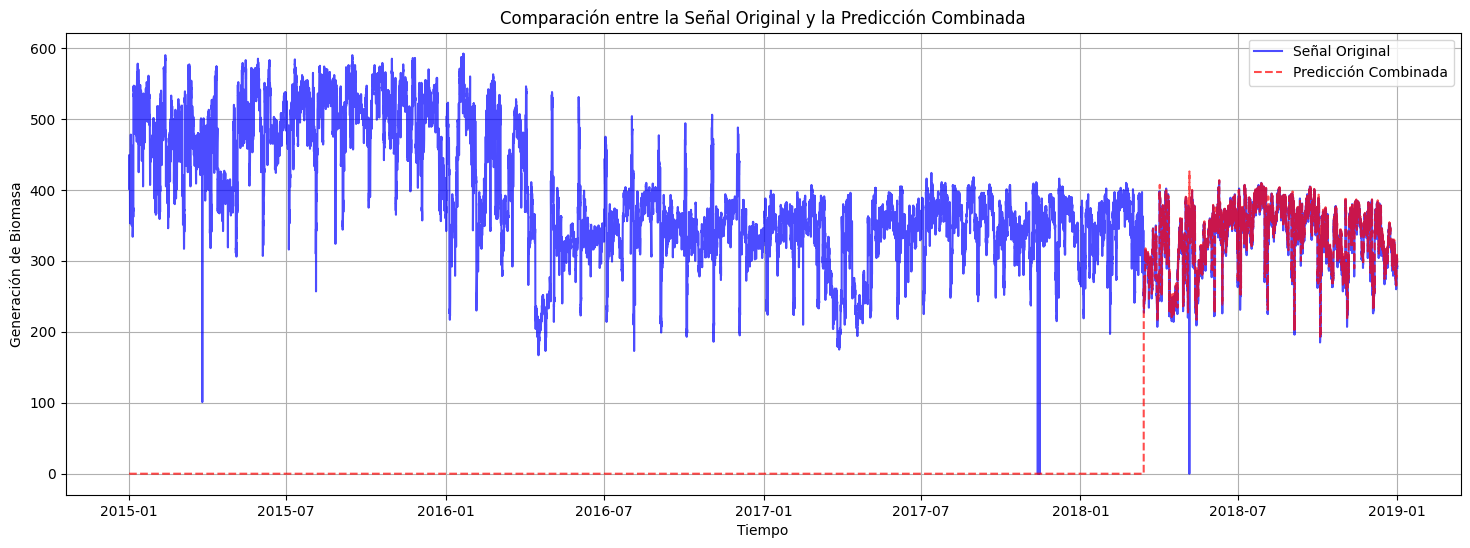

MSE (Combinado): 131701.49
MAE (Combinado): 318.46


In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Cargar el archivo CSV
df = pd.read_csv("energy_dataset.csv")

# Convertir la columna 'time' a formato datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

# Seleccionar la columna "generation biomass"
df_biomass = df[["time", "generation biomass"]]

# Rellenar valores faltantes usando interpolación lineal
df_biomass["generation biomass"] = df_biomass["generation biomass"].interpolate(method="linear")

# Dividir las muestras en pares e impares
grupo_pares = df_biomass.iloc[::2]  # Muestras pares (índices 0, 2, 4, ...)
grupo_impares = df_biomass.iloc[1::2]  # Muestras impares (índices 1, 3, 5, ...)

# Función para crear características y etiquetas
def create_features_labels(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

# Entrenar MLP para muestras pares
scaler_pares = MinMaxScaler()
grupo_pares["generation biomass"] = scaler_pares.fit_transform(grupo_pares[["generation biomass"]])
data_pares = grupo_pares["generation biomass"].values.reshape(-1, 1)
X_pares, y_pares = create_features_labels(data_pares, look_back=10)
X_train_pares, X_test_pares, y_train_pares, y_test_pares = train_test_split(X_pares, y_pares, test_size=0.2, shuffle=False)

model_pares = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_pares.compile(optimizer='adam', loss='mse')
model_pares.fit(X_train_pares, y_train_pares, epochs=50, batch_size=32, validation_data=(X_test_pares, y_test_pares), verbose=0)

# Entrenar MLP para muestras impares
scaler_impares = MinMaxScaler()
grupo_impares["generation biomass"] = scaler_impares.fit_transform(grupo_impares[["generation biomass"]])
data_impares = grupo_impares["generation biomass"].values.reshape(-1, 1)
X_impares, y_impares = create_features_labels(data_impares, look_back=10)
X_train_impares, X_test_impares, y_train_impares, y_test_impares = train_test_split(X_impares, y_impares, test_size=0.2, shuffle=False)

model_impares = Sequential([
    Dense(64, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_impares.compile(optimizer='adam', loss='mse')
model_impares.fit(X_train_impares, y_train_impares, epochs=50, batch_size=32, validation_data=(X_test_impares, y_test_impares), verbose=0)

# Generar predicciones para muestras pares e impares
y_pred_pares = model_pares.predict(X_test_pares)
y_pred_impares = model_impares.predict(X_test_impares)

# Desnormalizar las predicciones
y_pred_pares_rescaled = scaler_pares.inverse_transform(y_pred_pares)
y_pred_impares_rescaled = scaler_impares.inverse_transform(y_pred_impares)

# Combinar las predicciones en una sola serie temporal
# Crear un array vacío del mismo tamaño que la serie original
combined_predictions = np.zeros(len(df_biomass))

# Asignar las predicciones a las posiciones correspondientes
combined_predictions[::2][-len(y_pred_pares_rescaled):] = y_pred_pares_rescaled.flatten()
combined_predictions[1::2][-len(y_pred_impares_rescaled):] = y_pred_impares_rescaled.flatten()

# Comparar con la señal original
plt.figure(figsize=(18, 6))
plt.plot(df_biomass["time"], df_biomass["generation biomass"], label="Señal Original", color="blue", alpha=0.7)
plt.plot(df_biomass["time"], combined_predictions, label="Predicción Combinada", color="red", linestyle="--", alpha=0.7)
plt.title("Comparación entre la Señal Original y la Predicción Combinada")
plt.xlabel("Tiempo")
plt.ylabel("Generación de Biomasa")
plt.legend()
plt.grid(True)
plt.show()

# Calcular métricas de error
mse_combined = mean_squared_error(df_biomass["generation biomass"][-len(combined_predictions):], combined_predictions)
mae_combined = mean_absolute_error(df_biomass["generation biomass"][-len(combined_predictions):], combined_predictions)
print(f"MSE (Combinado): {mse_combined:.2f}")
print(f"MAE (Combinado): {mae_combined:.2f}")

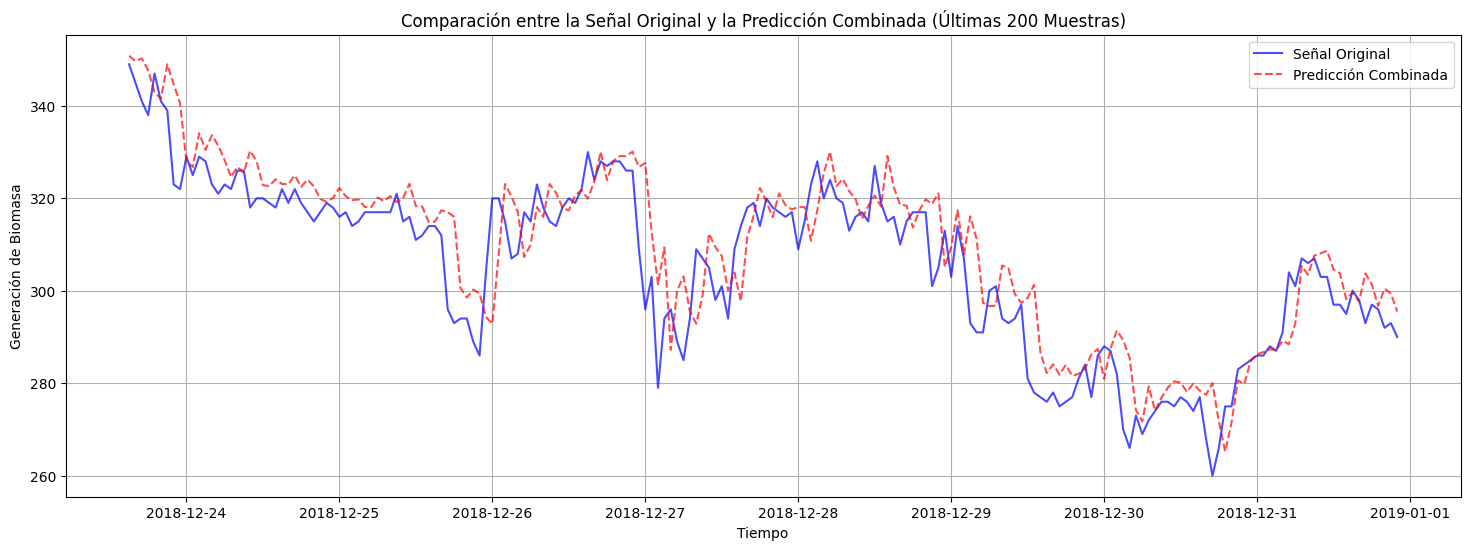

In [ ]:
# Obtener las últimas 200 muestras de la señal original y la predicción
ultimas_muestras_original = df_biomass["generation biomass"][-200:]
ultimas_muestras_prediccion = combined_predictions[-200:]

# Obtener los últimos 200 timestamps
ultimos_timestamps = df_biomass["time"][-200:]

# Visualizar las últimas 200 muestras
plt.figure(figsize=(18, 6))
plt.plot(ultimos_timestamps, ultimas_muestras_original, label="Señal Original", color="blue", alpha=0.7)
plt.plot(ultimos_timestamps, ultimas_muestras_prediccion, label="Predicción Combinada", color="red", linestyle="--", alpha=0.7)
plt.title("Comparación entre la Señal Original y la Predicción Combinada (Últimas 200 Muestras)")
plt.xlabel("Tiempo")
plt.ylabel("Generación de Biomasa")
plt.legend()
plt.grid(True)
plt.show()